In [1]:
#!pip install -q pysndfx SoundFile audiomentations pretrainedmodels efficientnet_pytorch resnest

In [2]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader

from resnest.torch import resnest50

from matplotlib import pyplot as plt

import os, random, gc
import re, time, json
from  ast import literal_eval


from IPython.display import Audio
from sklearn.metrics import label_ranking_average_precision_score

from tqdm.notebook import tqdm
import joblib

In [3]:
from efficientnet_pytorch import EfficientNet
import pretrainedmodels
import resnest.torch as resnest_torch

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [5]:
NUM_CLASSES = 397
SR = 32_000
DURATION = 7

MAX_READ_SAMPLES = 200 # Each record will have 10 melspecs at most, you can increase this on Colab with High Memory Enabled

# # For colab
#DATA_ROOT = Path("/content/datasets/")
#TRAIN_IMAGES_ROOT = Path("/content/datasets/audio_images")
#TRAIN_LABELS_FILE = Path("/content/datasets/rich_train_metadata.csv")

DATA_ROOT = Path("./train_data/kk")
TRAIN_IMAGES_ROOT = Path("./train_data/kk/audio_images")
TRAIN_LABELS_FILE = Path("./train_data/kk/rich_train_metadata.csv")

MEL_PATHS = sorted(Path("./train_data/kk").glob("rich_train_metadata.csv"))
TRAIN_LABEL_PATHS = sorted(Path("./train_data/kk").glob("LABEL_IDS.json"))

MODEL_ROOT = Path("./train_data/kk")

In [6]:
TRAIN_BATCH_SIZE = 80
TRAIN_NUM_WORKERS = 2

VAL_BATCH_SIZE = 128
VAL_NUM_WORKERS = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [7]:
def get_df(mel_paths=MEL_PATHS, train_label_paths=TRAIN_LABEL_PATHS):
  df = None
  LABEL_IDS = {}
    
  for file_path in mel_paths:
    temp = pd.read_csv(str(file_path), index_col=0)
    temp["impath"] = temp.apply(lambda row: file_path.parent/"audio_images/{}/{}.npy".format(row.primary_label, row.filename), axis=1) 
    df = temp if df is None else df.append(temp)
    
  df["secondary_labels"] = df["secondary_labels"].apply(literal_eval)

  for file_path in train_label_paths:
    with open(str(file_path)) as f:
      LABEL_IDS.update(json.load(f))

  return LABEL_IDS, df

In [8]:
LABEL_IDS, df = get_df()

In [9]:
def get_model(name, num_classes=NUM_CLASSES):
    """
    Loads a pretrained model. 
    Supports ResNest, ResNext-wsl, EfficientNet, ResNext and ResNet.

    Arguments:
        name {str} -- Name of the model to load

    Keyword Arguments:
        num_classes {int} -- Number of classes to use (default: {1})

    Returns:
        torch model -- Pretrained model
    """
    if "resnest" in name:
        model = getattr(resnest_torch, name)(pretrained=True)
    elif "wsl" in name:
        model = torch.hub.load("facebookresearch/WSL-Images", name)
    elif name.startswith("resnext") or  name.startswith("resnet"):
        model = torch.hub.load("pytorch/vision:v0.6.0", name, pretrained=True)
    elif name.startswith("tf_efficientnet_b"):
        model = getattr(timm.models.efficientnet, name)(pretrained=True)
    elif "efficientnet-b" in name:
        model = EfficientNet.from_pretrained(name)
    else:
        model = pretrainedmodels.__dict__[name](pretrained='imagenet')

    if hasattr(model, "fc"):
        nb_ft = model.fc.in_features
        model.fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "_fc"):
        nb_ft = model._fc.in_features
        model._fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "classifier"):
        nb_ft = model.classifier.in_features
        model.classifier = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "last_linear"):
        nb_ft = model.last_linear.in_features
        model.last_linear = nn.Linear(nb_ft, num_classes)

    return model

In [12]:
def load_data(df):
    def load_row(row):
        #impath = TRAIN_IMAGES_ROOT/f"{row.primary_label}/{row.filename}.npy"
        return row.filename, np.load(str(row.impath))[:MAX_READ_SAMPLES]
    pool = joblib.Parallel(12)
    mapper = joblib.delayed(load_row)
    tasks = [mapper(row) for row in df.itertuples(False)]
    res = pool(tqdm(tasks))
    res = dict(res)
    return res

In [13]:
audio_image_store = load_data(df)
len(audio_image_store)

  0%|          | 0/62874 [00:00<?, ?it/s]

62874

In [14]:
audio_image_store['XC109605.ogg'].shape

(13, 128, 281)

In [15]:
audio_image_store['XC157337.ogg'].shape

(6, 128, 281)

In [16]:
audio_image_store.keys()

dict_keys(['XC109605.ogg', 'XC11209.ogg', 'XC127032.ogg', 'XC129974.ogg', 'XC129981.ogg', 'XC130056.ogg', 'XC130133.ogg', 'XC130140.ogg', 'XC130750.ogg', 'XC131193.ogg', 'XC133047.ogg', 'XC135020.ogg', 'XC135121.ogg', 'XC136287.ogg', 'XC136290.ogg', 'XC136301.ogg', 'XC137858.ogg', 'XC137859.ogg', 'XC138090.ogg', 'XC138091.ogg', 'XC138092.ogg', 'XC157337.ogg', 'XC163936.ogg', 'XC166392.ogg', 'XC178213.ogg', 'XC178214.ogg', 'XC182091.ogg', 'XC197247.ogg', 'XC203555.ogg', 'XC215798.ogg', 'XC237866.ogg', 'XC240038.ogg', 'XC240101.ogg', 'XC244719.ogg', 'XC246420.ogg', 'XC247271.ogg', 'XC247436.ogg', 'XC247829.ogg', 'XC247837.ogg', 'XC247939.ogg', 'XC248218.ogg', 'XC248888.ogg', 'XC250814.ogg', 'XC250815.ogg', 'XC250816.ogg', 'XC254311.ogg', 'XC262224.ogg', 'XC262225.ogg', 'XC265805.ogg', 'XC275970.ogg', 'XC275971.ogg', 'XC284299.ogg', 'XC286544.ogg', 'XC299420.ogg', 'XC299456.ogg', 'XC302201.ogg', 'XC310335.ogg', 'XC31063.ogg', 'XC31224.ogg', 'XC31225.ogg', 'XC314750.ogg', 'XC316116.ogg', '

In [17]:
class BirdClefDataset(Dataset):

    def __init__(self, audio_image_store, meta, sr=SR, is_train=True, num_classes=NUM_CLASSES, duration=DURATION):
        
        self.audio_image_store = audio_image_store
        self.meta = meta.copy().reset_index(drop=True)
        self.sr = sr
        self.is_train = is_train
        self.num_classes = num_classes
        self.duration = duration
        self.audio_length = self.duration*self.sr
    
    @staticmethod
    def normalize(image):
        image = image.astype("float32", copy=False) / 255.0
        image = np.stack([image, image, image])
        return image

    def __len__(self):
        return len(self.meta)
    
    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        image = self.audio_image_store[row.filename]

        image = image[np.random.choice(len(image))]
        image = self.normalize(image)
        
        
        t = np.zeros(self.num_classes, dtype=np.float32) + 0.0025 # Label smoothing
        t[row.label_id] = 0.995
        
        return image, t

In [64]:
import matplotlib.pyplot as plt

def one_step( xb, yb, net, criterion, optimizer, scheduler=None):
  xb, yb = xb.to(DEVICE), yb.to(DEVICE)

  optimizer.zero_grad()
  o = net(xb)
  loss = criterion(o, yb)
  loss.backward()
  optimizer.step()
  
  with torch.no_grad():
      l = loss.item()

      o = o.sigmoid()
      yb = (yb > 0.5 )*1.0
      lrap = label_ranking_average_precision_score(yb.cpu().numpy(), o.cpu().numpy())

      o = (o > 0.5)*1.0

      prec = (o*yb).sum()/(1e-6 + o.sum())
      rec = (o*yb).sum()/(1e-6 + yb.sum())
      f1 = 2*prec*rec/(1e-6+prec+rec)

  if  scheduler is not None:
    scheduler.step()

  return l, lrap, f1.item(), rec.item(), prec.item()

In [65]:
@torch.no_grad()
def evaluate(net, criterion, val_laoder):
    net.eval()

    os, y = [], []
    val_laoder = tqdm(val_laoder, leave = False, total=len(val_laoder))

    for icount, (xb, yb) in  enumerate(val_laoder):

        y.append(yb.to(DEVICE))

        xb = xb.to(DEVICE)
        o = net(xb)
        print(o)

        os.append(o)

    y = torch.cat(y)
    o = torch.cat(os)

    l = criterion(o, y).item()
    
    o = o.sigmoid()
    y = (y > 0.5)*1.0

    lrap = label_ranking_average_precision_score(y.cpu().numpy(), o.cpu().numpy())

    o = (o > 0.5)*1.0

    prec = ((o*y).sum()/(1e-6 + o.sum())).item()
    rec = ((o*y).sum()/(1e-6 + y.sum())).item()
    f1 = 2*prec*rec/(1e-6+prec+rec)

    return l, lrap, f1, rec, prec, 

In [66]:
def one_epoch(net, criterion, optimizer, scheduler, train_laoder, val_laoder):
  net.train()
  l, lrap, prec, rec, f1, icount = 0.,0.,0.,0., 0., 0
  train_laoder = tqdm(train_laoder, leave = False)
  epoch_bar = train_laoder
  
  for (xb, yb) in  epoch_bar:
      # epoch_bar.set_description("----|----|----|----|---->")
      _l, _lrap, _f1, _rec, _prec = one_step(xb, yb, net, criterion, optimizer)
      l += _l
      lrap += _lrap
      f1 += _f1
      rec += _rec
      prec += _prec

      icount += 1
        
      if hasattr(epoch_bar, "set_postfix") and not icount%10:
          epoch_bar.set_postfix(
            loss="{:.6f}".format(l/icount),
            lrap="{:.3f}".format(lrap/icount),
            prec="{:.3f}".format(prec/icount),
            rec="{:.3f}".format(rec/icount),
            f1="{:.3f}".format(f1/icount),
          )
  
  scheduler.step()

  l /= icount
  lrap /= icount
  f1 /= icount
  rec /= icount
  prec /= icount
  
  l_val, lrap_val, f1_val, rec_val, prec_val = evaluate(net, criterion, val_laoder)
  
  return (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val)

In [67]:
class AutoSave:
  def __init__(self, top_k=2, metric="f1", mode="min", root=None, name="ckpt"):
    self.top_k = top_k
    self.logs = []
    self.metric = metric
    self.mode = mode
    self.root = Path(root or MODEL_ROOT)
    assert self.root.exists()
    self.name = name

    self.top_models = []
    self.top_metrics = []

  def log(self, model, metrics):
    metric = metrics[self.metric]
    rank = self.rank(metric)

    self.top_metrics.insert(rank+1, metric)
    if len(self.top_metrics) > self.top_k:
      self.top_metrics.pop(0)

    self.logs.append(metrics)
    self.save(model, metric, rank, metrics["epoch"])


  def save(self, model, metric, rank, epoch):
    t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_epoch_{:02d}_{}_{:.04f}_{}".format(self.name, epoch, self.metric, metric, t)
    name = re.sub(r"[^\w_-]", "", name) + ".pth"
    path = self.root.joinpath(name)

    old_model = None
    self.top_models.insert(rank+1, name)
    if len(self.top_models) > self.top_k:
      old_model = self.root.joinpath(self.top_models[0])
      self.top_models.pop(0)      

    torch.save(model.state_dict(), path.as_posix())

    if old_model is not None:
      old_model.unlink()

    self.to_json()


  def rank(self, val):
    r = -1
    for top_val in self.top_metrics:
      if val <= top_val:
        return r
      r += 1

    return r
  
  def to_json(self):
    # t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_logs".format(self.name)
    name = re.sub(r"[^\w_-]", "", name) + ".json"
    path = self.root.joinpath(name)

    with path.open("w") as f:
      json.dump(self.logs, f, indent=2)

In [68]:
def one_fold(model_name, fold, train_set, val_set, epochs=20, save=True, save_root=None):

  save_root = Path(save_root) or MODEL_ROOT

  saver = AutoSave(root=save_root, name=f"birdclef_{model_name}_fold{fold}", metric="f1_val")

  net = get_model(model_name).to(DEVICE)

  criterion = nn.BCEWithLogitsLoss()

  optimizer = optim.Adam(net.parameters(), lr=8e-4)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=epochs)

  train_data = BirdClefDataset(audio_image_store, meta=df.iloc[train_set].reset_index(drop=True),
                           sr=SR, duration=DURATION, is_train=True)
  train_laoder = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=TRAIN_NUM_WORKERS, shuffle=True, pin_memory=True)

  val_data = BirdClefDataset(audio_image_store, meta=df.iloc[val_set].reset_index(drop=True),  sr=SR, duration=DURATION, is_train=False)
  val_laoder = DataLoader(val_data, batch_size=VAL_BATCH_SIZE, num_workers=VAL_NUM_WORKERS, shuffle=False)

  epochs_bar = tqdm(list(range(epochs)), leave=False)
  for epoch  in epochs_bar:
    epochs_bar.set_description(f"--> [EPOCH {epoch:02d}]")
    net.train()

    (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val) = one_epoch(
        net=net,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_laoder=train_laoder,
        val_laoder=val_laoder,
      )

    epochs_bar.set_postfix(
    loss="({:.6f}, {:.6f})".format(l, l_val),
    prec="({:.3f}, {:.3f})".format(prec, prec_val),
    rec="({:.3f}, {:.3f})".format(rec, rec_val),
    f1="({:.3f}, {:.3f})".format(f1, f1_val),
    lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
    )

    print(
        "[{epoch:02d}] loss: {loss} lrap: {lrap} f1: {f1} rec: {rec} prec: {prec}".format(
            epoch=epoch,
            loss="({:.6f}, {:.6f})".format(l, l_val),
            prec="({:.3f}, {:.3f})".format(prec, prec_val),
            rec="({:.3f}, {:.3f})".format(rec, rec_val),
            f1="({:.3f}, {:.3f})".format(f1, f1_val),
            lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
        )
    )

    if save:
      metrics = {
          "loss": l, "lrap": lrap, "f1": f1, "rec": rec, "prec": prec,
          "loss_val": l_val, "lrap_val": lrap_val, "f1_val": f1_val, "rec_val": rec_val, "prec_val": prec_val,
          "epoch": epoch,
      }

      saver.log(net, metrics)

In [69]:
def train(model_name, epochs=20, save=True, n_splits=5, seed=177, save_root=None, suffix="", folds=None):
  gc.collect()
  torch.cuda.empty_cache()

  save_root = save_root or MODEL_ROOT/f"{model_name}{suffix}"
  save_root.mkdir(exist_ok=True, parents=True)
  
  fold_bar = tqdm(df.reset_index().groupby("fold").index.apply(list).items(), total=df.fold.max()+1)
  
  for fold, val_set in fold_bar:
      if folds and not fold in folds:
        continue
      
      print(f"\n############################### [FOLD {fold}]")
      fold_bar.set_description(f"[FOLD {fold}]")
      train_set = np.setdiff1d(df.index, val_set)
        
      one_fold(model_name, fold=fold, train_set=train_set , val_set=val_set , epochs=epochs, save=save, save_root=save_root)
    
      gc.collect()
      torch.cuda.empty_cache()

In [70]:
MODEL_NAMES = [
      #"efficientnet-b0",
      "resnest50",
] 



########################################### RESNEST50


  0%|          | 0/5 [00:00<?, ?it/s]


############################### [FOLD 0]
ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (c

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/629 [00:00<?, ?it/s]

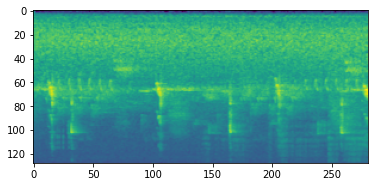

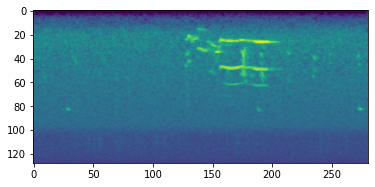

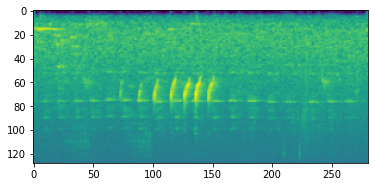

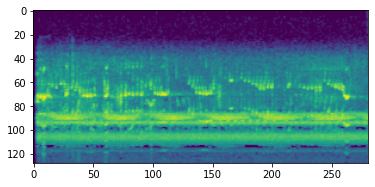

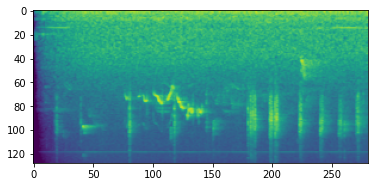

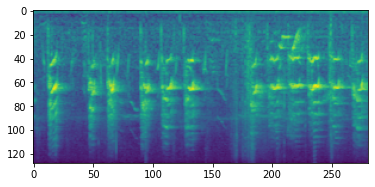

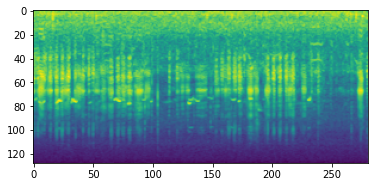

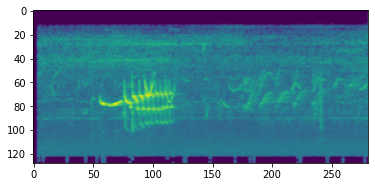

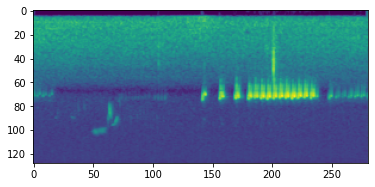

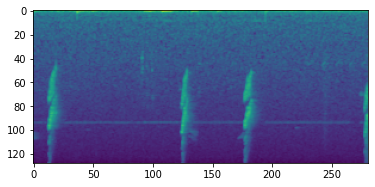

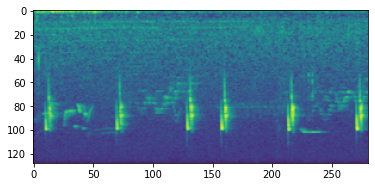

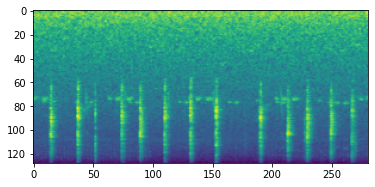

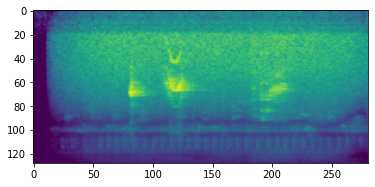

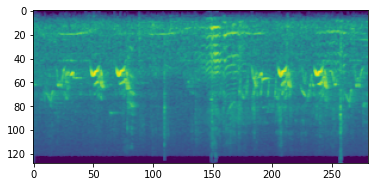

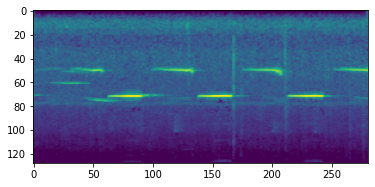

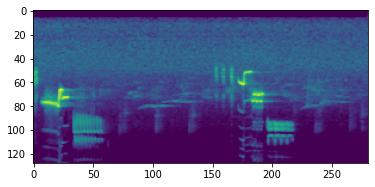

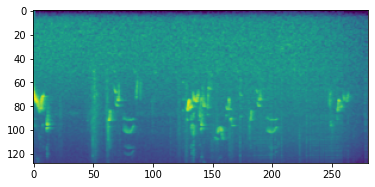

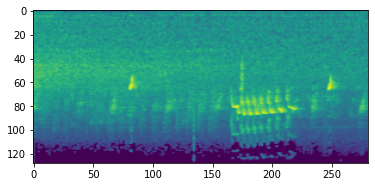

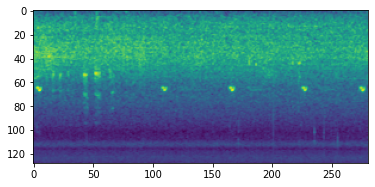

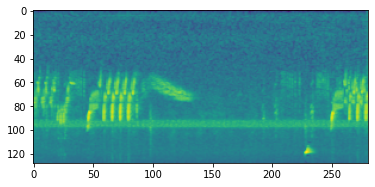

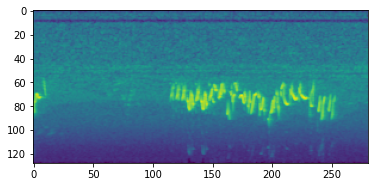

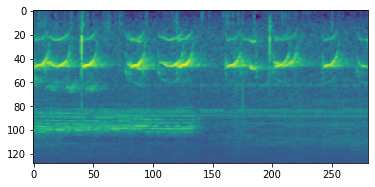

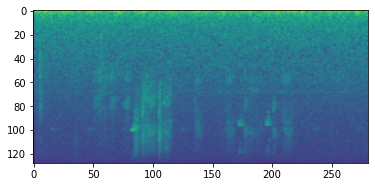

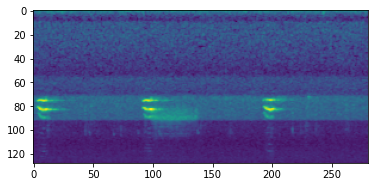

KeyboardInterrupt: 

In [71]:
for model_name in MODEL_NAMES:
  print("\n\n###########################################", model_name.upper())
  try:
    train(model_name, epochs=20, suffix=f"_sr{SR}_d{DURATION}_v1_v1", folds=[0,1,2,3,4])
  except Exception as e:
    print(f"Error {model_name} : \n{e}")
    raise ValueError() from  e

In [27]:
net

NameError: name 'net' is not defined